In [0]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
import re
from nltk.corpus import stopwords
import pickle
from tqdm import tqdm
import os

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
#we already have data available for all the initials we need fot poject title text and the data for pre=oject summary here

In [0]:
#loading the data
project_data = pd.read_csv('train_data.csv')
resource_data = pd.read_csv('resources.csv')

In [0]:
#merging both the data to get a final dataset
price_data = resource_data.groupby('id').agg({'price':'sum','quantity':'sum'}).reset_index()
price_data.head(2)

,id,price,quantity
0,p000001,459.56,7
1,p000002,515.89,21


In [0]:
project_data = pd.merge(project_data,price_data,on = 'id',how = 'left')#getting the final dataset

In [0]:
#print(project_data.columns)
project_data.head(2)

,Unnamed: 0,id,teacher_id,teacher_prefix,school_state,project_submitted_datetime,project_grade_category,project_subject_categories,project_subject_subcategories,project_title,project_essay_1,project_essay_2,project_essay_3,project_essay_4,project_resource_summary,teacher_number_of_previously_posted_projects,project_is_approved,price,quantity
0,160221,p253737,c90749f5d961ff158d4b4d1e7dc665fc,Mrs.,IN,2016-12-05 13:43:57,Grades PreK-2,Literacy & Language,"ESL, Literacy",Educational Support for English Learners at Home,My students are English learners that are work...,"\""The limits of your language are the limits o...",NaN,NaN,My students need opportunities to practice beg...,0,0,154.6,23
1,140945,p258326,897464ce9ddc600bced1151f324dd63a,Mr.,FL,2016-10-25 09:22:10,Grades 6-8,"History & Civics, Health & Sports","Civics & Government, Team Sports",Wanted: Projector for Hungry Learners,Our students arrive to our school eager to lea...,The projector we need for our school is very c...,NaN,NaN,My students need a projector to help with view...,7,1,299.0,1


In [0]:
target = project_data['project_is_approved']
project_data.drop(['Unnamed: 0','id','teacher_id','project_is_approved'],axis = 1,inplace = True)


In [0]:
print('shape of the final data is:',project_data.shape)
print('Shape of target variable is:',target.shape)
print('Features of the final dataset is:',project_data.columns)

shape of the final data is: (109248, 15)
Shape of target variable is: (109248,)
Features of the final dataset is: Index(['teacher_prefix', 'school_state', 'project_submitted_datetime',
       'project_grade_category', 'project_subject_categories',
       'project_subject_subcategories', 'project_title', 'project_essay_1',
       'project_essay_2', 'project_essay_3', 'project_essay_4',
       'project_resource_summary',
       'teacher_number_of_previously_posted_projects', 'price', 'quantity'],
      dtype='object')


so we have following final features

__Categorical Features__:

    - Teacher_prefix
    - school_stae
    - project_grade_category
    - project_subject_categories
    - project_subject_subcategories
  
__Text Features__:

    - project essay 1
    - project essay 2
    - project essay 3
    - project essay 4
    - project resource summary
    - project title
    
__Numerical Feature__:

    - teacher number of previously posted categories
    - quantity
    - price

# Preprocessing the features 

## 1.Preprocessing the categorical features 

### project_grade_category

In [0]:
# https://stackoverflow.com/questions/36383821/pandas-dataframe-apply-function-to-column-strings-based-on-other-column-value
project_data['project_grade_category'] = project_data['project_grade_category'].str.replace(' ','_')
project_data['project_grade_category'] = project_data['project_grade_category'].str.replace('-','_')
project_data['project_grade_category'] = project_data['project_grade_category'].str.lower()
project_data['project_grade_category'].value_counts()

grades_prek_2    44225
grades_3_5       37137
grades_6_8       16923
grades_9_12      10963
Name: project_grade_category, dtype: int64

### project_subject_category

In [0]:
project_data['project_subject_categories'] = project_data['project_subject_categories'].str.replace(' The ','')
project_data['project_subject_categories'] = project_data['project_subject_categories'].str.replace(' ','')
project_data['project_subject_categories'] = project_data['project_subject_categories'].str.replace('&','_')
project_data['project_subject_categories'] = project_data['project_subject_categories'].str.replace(',','_')
project_data['project_subject_categories'] = project_data['project_subject_categories'].str.lower()
project_data['project_subject_categories'].value_counts()

literacy_language                       23655
math_science                            17072
literacy_language_math_science          14636
health_sports                           10177
music_arts                               5180
specialneeds                             4226
literacy_language_specialneeds           3961
appliedlearning                          3771
math_science_literacy_language           2289
appliedlearning_literacy_language        2191
history_civics                           1851
math_science_specialneeds                1840
literacy_language_music_arts             1757
math_science_music_arts                  1642
appliedlearning_specialneeds             1467
history_civics_literacy_language         1421
health_sports_specialneeds               1391
warmth_care_hunger                       1309
math_science_appliedlearning             1220
appliedlearning_math_science             1052
literacy_language_history_civics          809
health_sports_literacy_language   

### Teacher prefix

In [0]:
# check if we have any nan values are there
print(project_data['teacher_prefix'].isnull().values.any())
print("number of nan values",project_data['teacher_prefix'].isnull().values.sum())

True
number of nan values 3


>numebr of missing values are very less in number, we can replace it with Mrs. as most of the projects are submitted by Mrs.

In [0]:
project_data['teacher_prefix']=project_data['teacher_prefix'].fillna('Mrs.')
project_data['teacher_prefix'] = project_data['teacher_prefix'].str.replace('.','')
project_data['teacher_prefix'] = project_data['teacher_prefix'].str.lower()
project_data['teacher_prefix'].value_counts()

mrs        57272
ms         38955
mr         10648
teacher     2360
dr            13
Name: teacher_prefix, dtype: int64

### Project subject subcategories

In [0]:
project_data['project_subject_subcategories'] = project_data['project_subject_subcategories'].str.replace(' The ','')
project_data['project_subject_subcategories'] = project_data['project_subject_subcategories'].str.replace(' ','')
project_data['project_subject_subcategories'] = project_data['project_subject_subcategories'].str.replace('&','_')
project_data['project_subject_subcategories'] = project_data['project_subject_subcategories'].str.replace(',','_')
project_data['project_subject_subcategories'] = project_data['project_subject_subcategories'].str.lower()
project_data['project_subject_subcategories'].value_counts()

literacy                              9486
literacy_mathematics                  8325
literature_writing_mathematics        5923
literacy_literature_writing           5571
mathematics                           5379
                                      ... 
gym_fitness_warmth_care_hunger           1
civics_government_foreignlanguages       1
economics_nutritioneducation             1
financialliteracy_performingarts         1
extracurricular_financialliteracy        1
Name: project_subject_subcategories, Length: 401, dtype: int64

### School state

In [0]:
project_data['school_state'] = project_data['school_state'].str.lower()
project_data['school_state'].value_counts()

ca    15388
tx     7396
ny     7318
fl     6185
nc     5091
il     4350
ga     3963
sc     3936
mi     3161
pa     3109
in     2620
mo     2576
oh     2467
la     2394
ma     2389
wa     2334
ok     2276
nj     2237
az     2147
va     2045
wi     1827
al     1762
ut     1731
tn     1688
ct     1663
md     1514
nv     1367
ms     1323
ky     1304
or     1242
mn     1208
co     1111
ar     1049
id      693
ia      666
ks      634
nm      557
dc      516
hi      507
me      505
wv      503
nh      348
ak      345
de      343
ne      309
sd      300
ri      285
mt      245
nd      143
wy       98
vt       80
Name: school_state, dtype: int64

## 2.Preproocessing text features

In [0]:
#writing the utility functions for text cleaning 
from tqdm import tqdm
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
stopwords= ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"]

#========================================================================================================
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    """Function for opening thee decontracted words"""
    # specific
    phrase = re.sub(r"won't", "will not", phrase)#converting to will not
    phrase = re.sub(r"can\'t", "can not", phrase)#converting to can not

    # general
    phrase = re.sub(r"n\'t", " not", phrase)#converting to not
    phrase = re.sub(r"\'re", " are", phrase)#converting to are
    phrase = re.sub(r"\'s", " is", phrase)#converting to is
    phrase = re.sub(r"\'d", " would", phrase)#converting to would
    phrase = re.sub(r"\'ll", " will", phrase)#converting to will
    phrase = re.sub(r"\'t", " not", phrase)#converting to not
    phrase = re.sub(r"\'ve", " have", phrase)#converting to have
    phrase = re.sub(r"\'m", " am", phrase)#converting to am
    return phrase
#=============================================================================================

# Combining all the above stundents 
def preprocess_text(text_data):
    """cleaning and remving the stopwords"""
    preprocessed_text = []
    # tqdm is for printing the status bar
    for sentance in tqdm(text_data):
        sent = decontracted(sentance)
        sent = sent.replace('\\r', ' ')
        sent = sent.replace('\\n', ' ')
        sent = sent.replace('\\"', ' ')
        sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
        # https://gist.github.com/sebleier/554280
        sent = ' '.join(e for e in sent.split() if e.lower() not in stopwords)
        preprocessed_text.append(sent.lower().strip())
    return preprocessed_text

### project title


In [0]:
preprocessed_titles = preprocess_text(project_data['project_title'].values)

100%|███████████████████████████████████████████████████████████████████████| 109248/109248 [00:05<00:00, 19899.20it/s]


In [0]:
project_data['cleaned_project_titles'] = preprocessed_titles
project_data.drop(['project_title'],axis = 1,inplace = True)

### Project resource summary

In [0]:
preprocessed_resource_summary = preprocess_text(project_data['project_resource_summary'].values)
project_data['cleaned_resource_summary'] = preprocessed_resource_summary
project_data.drop(['project_resource_summary'],axis = 1,inplace = True)

100%|████████████████████████████████████████████████████████████████████████| 109248/109248 [00:10<00:00, 9999.71it/s]


### project essays

In [0]:
# merge two column text dataframe: 
project_data["essay"] = project_data["project_essay_1"].map(str) +\
                        project_data["project_essay_2"].map(str) + \
                        project_data["project_essay_3"].map(str) + \
                        project_data["project_essay_4"].map(str)

In [0]:
preprocessed_essays = preprocess_text(project_data['essay'].values)
project_data['cleaned_essay'] = preprocessed_essays
project_data.drop(['project_essay_1','project_essay_2','project_essay_3','project_essay_4'],axis = 1,inplace = True)

100%|█████████████████████████████████████████████████████████████████████████| 109248/109248 [02:04<00:00, 874.01it/s]


## 3.Preprocessing nuerical features 

### MinmaxScaler

In [0]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(project_data['price'].values.reshape(-1, 1))
project_data['nrm_price']=scaler.transform(project_data['price'].values.reshape(-1, 1))
project_data
project_data.head(2)

,teacher_prefix,school_state,project_submitted_datetime,project_grade_category,project_subject_categories,project_subject_subcategories,teacher_number_of_previously_posted_projects,price,quantity,cleaned_project_titles,cleaned_resource_summary,cleaned_essay,nrm_price
0,mrs,in,2016-12-05 13:43:57,grades_prek_2,literacy_language,esl_literacy,0,154.6,23,educational support english learners home,students need opportunities practice beginning...,students english learners working english seco...,0.015397
1,mr,fl,2016-10-25 09:22:10,grades_6_8,history_civics_health_sports,civics_government_teamsports,7,299.0,1,wanted projector hungry learners,students need projector help viewing education...,students arrive school eager learn polite gene...,0.029839


In [0]:
#Save the processed dataset into a pandas CSV file.
project_data.to_csv("processed_data.csv", index=False)

# Preparing the data for modelling 

- Vectorizing categorical features using one hot encoding

- Vectorizing text data using BOW or TFIDF/W2V TFIDF

- Standardizing or normalizing numerical data 

In [0]:
#splitting the data
project_data = pd.read_csv('processed_data.csv')
project_data.head(2)

,teacher_prefix,school_state,project_submitted_datetime,project_grade_category,project_subject_categories,project_subject_subcategories,teacher_number_of_previously_posted_projects,price,quantity,cleaned_project_titles,cleaned_resource_summary,cleaned_essay,nrm_price
0,mrs,in,2016-12-05 13:43:57,grades_prek_2,literacy_language,esl_literacy,0,154.6,23,educational support english learners home,students need opportunities practice beginning...,students english learners working english seco...,0.015397
1,mr,fl,2016-10-25 09:22:10,grades_6_8,history_civics_health_sports,civics_government_teamsports,7,299.0,1,wanted projector hungry learners,students need projector help viewing education...,students arrive school eager learn polite gene...,0.029839


In [0]:
project_data.columns

Index(['teacher_prefix', 'school_state', 'project_submitted_datetime',
       'project_grade_category', 'project_subject_categories',
       'project_subject_subcategories',
       'teacher_number_of_previously_posted_projects', 'price', 'quantity',
       'cleaned_project_titles', 'cleaned_resource_summary', 'cleaned_essay',
       'nrm_price'],
      dtype='object')

In [0]:
#splitting the data in train,validation and test 
from sklearn.model_selection import train_test_split
#80% training data and 20% test data 
X_train,X_test,Y_train,Y_test = train_test_split(project_data,target,test_size = 0.2,stratify = target,random_state = 42)
X_train,X_cv,Y_train,Y_cv = train_test_split(X_train,Y_train,test_size = 0.2,stratify = Y_train,random_state = 42)

print('shape of training data after vectorization is:',X_train.shape)
print('shape of validation data after vectorization is:',X_cv.shape)
print('shape of test data after vectorization is:',X_test.shape)

In [0]:
print('shape of training data after vectorization is:',X_train.shape)
print('shape of validation data after vectorization is:',X_cv.shape)
print('shape of test data after vectorization is:',X_test.shape)

shape of training data after vectorization is: (69918, 13)
shape of validation data after vectorization is: (17480, 13)
shape of test data after vectorization is: (21850, 13)


In [3]:
#trying the embeddings 
from keras.models import Sequential
from keras.preprocessing import sequence
from keras.initializers import he_normal
from keras.layers import Input
from keras.layers import Dense
from keras.layers.embeddings import Embedding
from keras.regularizers import L1L2
from keras.layers import BatchNormalization
from keras.layers import Dropout
from keras.layers import LSTM
from keras.layers import Flatten
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model
from keras.layers import concatenate
from sklearn.metrics import accuracy_score
from IPython.core.display import display,HTML
from numpy import zeros
display(HTML("<style>.container { width:100% !important; }</style>"))

Using TensorFlow backend.


## 2. Vectorizing the categorical features 

### 2.1 Project_category

In [0]:
from collections import Counter 
def count(df):
    
    """Returns the sorted dinctionary keys"""
    my_counter = Counter() #initiating counter to calculate occurence of words
    for word in df.values:
        my_counter.update(word.split())
    
# dict sort by value python: https://stackoverflow.com/a/613218/4084039
    cat_dict = dict(my_counter)
    sorted_cat_dict = dict(sorted(cat_dict.items(), key=lambda kv: kv[1]))
    return sorted_cat_dict

In [0]:

# we use count vectorizer to convert the values into one hot encoded features
from sklearn.feature_extraction.text import CountVectorizer
cat_dict = count(project_data['project_subject_categories'])
vectorizer = CountVectorizer(vocabulary=list(cat_dict.keys()), lowercase=False, binary=True)
vectorizer.fit(X_train['project_subject_categories'].values)
print(vectorizer.get_feature_names()[:10])


train_categories = vectorizer.transform(X_train['project_subject_categories'].values)
val_categories = vectorizer.transform(X_cv['project_subject_categories'].values)
test_categories = vectorizer.transform(X_test['project_subject_categories'].values)
print("Shape of train matrix after one hot encodig ",train_categories.shape)
print("Shape of val matrix after one hot encodig ",val_categories.shape)
print("Shape of test matrix after one hot encodig ",test_categories.shape)

#vocab_size_categories = train_categories.shape[1] + 1


['history_civics_warmth_care_hunger', 'music_arts_warmth_care_hunger', 'literacy_language_warmth_care_hunger', 'music_arts_appliedlearning', 'appliedlearning_warmth_care_hunger', 'math_science_warmth_care_hunger', 'history_civics_health_sports', 'music_arts_history_civics', 'music_arts_health_sports', 'health_sports_warmth_care_hunger']
Shape of train matrix after one hot encodig  (69918, 51)
Shape of val matrix after one hot encodig  (17480, 51)
Shape of test matrix after one hot encodig  (21850, 51)


In [0]:
#getting the embedding layer 
#Get the flattened output for clean_categories
input_layer_clean_categories = Input(shape=(train_categories.shape[1],), name = "input_categories")
embedding_layer_clean_categories = Embedding(input_dim=train_categories.shape[1], output_dim=4, trainable=True)(input_layer_clean_categories)
flatten_clean_categories = Flatten()(embedding_layer_clean_categories)

### 2.2 Project subcategories

In [0]:
# we use count vectorizer to convert the values into one hot encoded features
#from sklearn.feature_extraction.text import CountVectorizer
cat_dict = count(project_data['project_subject_subcategories'])
vectorizer = CountVectorizer(vocabulary=list(cat_dict.keys()), lowercase=False, binary=True)
vectorizer.fit(X_train['project_subject_subcategories'].values)
print(vectorizer.get_feature_names()[:10])


train_subcategories = vectorizer.transform(X_train['project_subject_subcategories'].values)
val_subcategories = vectorizer.transform(X_cv['project_subject_subcategories'].values)
test_subcategories = vectorizer.transform(X_test['project_subject_subcategories'].values)
print("Shape of train matrix after one hot encodig ",train_subcategories.shape)
print("Shape of val matrix after one hot encodig ",val_subcategories.shape)
print("Shape of test matrix after one hot encodig ",test_subcategories.shape)


['gym_fitness_parentinvolvement', 'communityservice_gym_fitness', 'college_careerprep_warmth_care_hunger', 'economics_other', 'parentinvolvement_warmth_care_hunger', 'communityservice_music', 'gym_fitness_socialsciences', 'parentinvolvement_teamsports', 'civics_government_nutritioneducation', 'financialliteracy_foreignlanguages']
Shape of train matrix after one hot encodig  (69918, 401)
Shape of val matrix after one hot encodig  (17480, 401)
Shape of test matrix after one hot encodig  (21850, 401)


In [0]:
#getting the embedding layer 
#Get the flattened output for clean_subcategories
input_layer_subcategories = Input(shape=(train_subcategories.shape[1],), name = "input_subcategories")
embedding_layer_subcategories = Embedding(input_dim=train_subcategories.shape[1], output_dim=4, trainable=True)(input_layer_subcategories)
flatten_subcategories = Flatten()(embedding_layer_subcategories)

### 2.3 Teacher Prefix

In [0]:
cat_dict = count(project_data['teacher_prefix'])
vectorizer = CountVectorizer(vocabulary=list(cat_dict.keys()), lowercase=False, binary=True)
vectorizer.fit(X_train['teacher_prefix'].values)
print(vectorizer.get_feature_names()[:10])


train_prefix = vectorizer.transform(X_train['teacher_prefix'].values)
val_prefix = vectorizer.transform(X_cv['teacher_prefix'].values)
test_prefix= vectorizer.transform(X_test['teacher_prefix'].values)
print("Shape of train matrix after one hot encodig ",train_prefix.shape)
print("Shape of val matrix after one hot encodig ",val_prefix.shape)
print("Shape of test matrix after one hot encodig ",test_prefix.shape)


['dr', 'teacher', 'mr', 'ms', 'mrs']
Shape of train matrix after one hot encodig  (69918, 5)
Shape of val matrix after one hot encodig  (17480, 5)
Shape of test matrix after one hot encodig  (21850, 5)


In [0]:
#getting the embedding layer 
#Get the flattened output for teacher_prefix
input_layer_prefix = Input(shape=(train_prefix.shape[1],), name = "input_prefix")
embedding_layer_prefix = Embedding(input_dim=train_prefix.shape[1], output_dim=4, trainable=True)(input_layer_prefix)
flatten_prefix = Flatten()(embedding_layer_prefix)

### 2.4School state

In [0]:
cat_dict = count(project_data['school_state'])
vectorizer = CountVectorizer(vocabulary=list(cat_dict.keys()), lowercase=False, binary=True)
vectorizer.fit(X_train['school_state'].values)
print(vectorizer.get_feature_names())


train_state = vectorizer.transform(X_train['school_state'].values)
val_state = vectorizer.transform(X_cv['school_state'].values)
test_state= vectorizer.transform(X_test['school_state'].values)
print("Shape of train matrix after one hot encodig ",train_state.shape)
print("Shape of val matrix after one hot encodig ",val_state.shape)
print("Shape of test matrix after one hot encodig ",test_state.shape)

['vt', 'wy', 'nd', 'mt', 'ri', 'sd', 'ne', 'de', 'ak', 'nh', 'wv', 'me', 'hi', 'dc', 'nm', 'ks', 'ia', 'id', 'ar', 'co', 'mn', 'or', 'ky', 'ms', 'nv', 'md', 'ct', 'tn', 'ut', 'al', 'wi', 'va', 'az', 'nj', 'ok', 'wa', 'ma', 'la', 'oh', 'mo', 'in', 'pa', 'mi', 'sc', 'ga', 'il', 'nc', 'fl', 'ny', 'tx', 'ca']
Shape of train matrix after one hot encodig  (69918, 51)
Shape of val matrix after one hot encodig  (17480, 51)
Shape of test matrix after one hot encodig  (21850, 51)


In [0]:
#getting the embedding layer 
#Get the flattened output for clean_subcategories
input_layer_state = Input(shape=(train_state.shape[1],), name = "input_state")
embedding_layer_state = Embedding(input_dim=train_state.shape[1], output_dim=4, trainable=True)(input_layer_state)
flatten_state = Flatten()(embedding_layer_state)

### 2.5 Project grade category

In [0]:
cat_dict = count(project_data['project_grade_category'])
vectorizer = CountVectorizer(vocabulary=list(cat_dict.keys()), lowercase=False, binary=True)
vectorizer.fit(X_train['project_grade_category'].values)
print(vectorizer.get_feature_names()[:10])


train_grade_category = vectorizer.transform(X_train['project_grade_category'].values)
val_grade_category = vectorizer.transform(X_cv['project_grade_category'].values)
test_grade_category= vectorizer.transform(X_test['project_grade_category'].values)
print("Shape of train matrix after one hot encodig ",train_grade_category.shape)
print("Shape of val matrix after one hot encodig ",val_grade_category.shape)
print("Shape of test matrix after one hot encodig ",test_grade_category.shape)

['grades_9_12', 'grades_6_8', 'grades_3_5', 'grades_prek_2']
Shape of train matrix after one hot encodig  (69918, 4)
Shape of val matrix after one hot encodig  (17480, 4)
Shape of test matrix after one hot encodig  (21850, 4)


In [0]:
#getting the embedding layer 
#Get the flattened output for project grade category
input_layer_grade_category = Input(shape=(train_grade_category.shape[1],), name = "input_grade_category")
embedding_layer_grade_category = Embedding(input_dim=train_grade_category.shape[1], output_dim=4, trainable=True)(input_layer_grade_category)
flatten_grade_category = Flatten()(embedding_layer_grade_category)

## Vectorizing the text data 

as we want to input the total text that's why we must get the final text by combining all

In [0]:
#utility function
def final_text(df):
    """Returns the final concatenated text"""
    df['final_Text'] = df['cleaned_essay'].map(str) + " " + df['cleaned_resource_summary'].map(str) +\
        " " + df['cleaned_project_titles'].map(str)
    return df

#getting the train,val and test data
train_text = final_text(X_train)
val_text = final_text(X_cv)
test_text = final_text(X_test)

In [0]:
#building the data for modelling


#initializing the tokenizer
tokens = Tokenizer()
tokens.fit_on_texts(list(train_text['final_Text'].values))#will convert texts to sequences 

#integer encoding the documents
docs_train = tokens.texts_to_sequences(list(train_text['final_Text'].values))
docs_val = tokens.texts_to_sequences(list(val_text['final_Text'].values))
docs_test = tokens.texts_to_sequences(list(test_text['final_Text'].values))

vocab_size = len(tokens.word_index) + 1

max_length = 300#for padding the sequences 

#finally padding the squences
padded_docs_train = pad_sequences(docs_train, maxlen=max_length, padding='post')
padded_docs_val = pad_sequences(docs_val, maxlen=max_length, padding='post')
padded_docs_test = pad_sequences(docs_test, maxlen=max_length, padding='post')

#creating a matrix for each word in training data 
pickle_in = open("glove_vectors","rb")
glove_words = pickle.load(pickle_in)
embedding_matrix = zeros((vocab_size, 300))
for word, i in tokens.word_index.items(): #enumerating all unique words
    embedding_vector = glove_words.get(word)#locating for loaded glove model
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [0]:
vocab_size

51153

In [0]:
#as we choose the vector to be 300 dimensional
#that's why the output dimension must be 300
input_text_layer = Input(shape = (300,),name = 'input_total_text_sequence')
embedding_layer_text = Embedding(input_dim = vocab_size,output_dim = 300,weights = [embedding_matrix],trainable = False)(input_text_layer)
#here input_dim is size of vocablury of text data
#output_dim is size of embedded vector

In [0]:
#lstm for this layer
lstm_layer = LSTM(32,activation = 'relu',return_sequences = True)(embedding_layer_text)
#and finally flttening the output
flatten_text = Flatten()(lstm_layer)

# Normalizing the numerical data

### Teacher number of previously posted projects

In [0]:
from sklearn.preprocessing import Normalizer

norm = Normalizer()
train_ppp = norm.fit_transform(X_train['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))
val_ppp = norm.transform(X_cv['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))
test_ppp = norm.transform(X_test['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))

In [0]:
train_ppp = train_ppp.reshape(len(X_train),1)
val_ppp = val_ppp.reshape(len(X_cv),1)
test_ppp = test_ppp.reshape(len(X_test),1)

In [0]:
input_num_1 = Input(shape = (train_ppp.shape[1],),name = 'input_previously_posted_projects')

### Quantity

In [0]:
norm = Normalizer()
train_quantity = norm.fit_transform(X_train.quantity.values.reshape(-1,1))
val_quantity = norm.transform(X_cv.quantity.values.reshape(-1,1))
test_quantity = norm.transform(X_test.quantity.values.reshape(-1,1))

train_quantity = train_quantity.reshape(len(X_train),1)
val_quantity = val_quantity.reshape(len(X_cv),1)
test_quantity = test_quantity.reshape(len(X_test),1)


In [0]:
input_num_2 = Input(shape = (train_quantity.shape[1],),name = 'input_quantity')

### Price

In [0]:
norm = Normalizer()
train_price = norm.fit_transform(X_train.price.values.reshape(-1,1))
val_price = norm.fit_transform(X_cv.price.values.reshape(-1,1))
test_price = norm.fit_transform(X_test.price.values.reshape(-1,1))

train_price = train_price.reshape(len(X_train),1)
val_price = val_price.reshape(len(X_cv),1)
test_price = test_price.reshape(len(X_test),1)

In [0]:
input_num_3 = Input(shape = (train_price.shape[1],),name = 'input_price')

In [0]:
#concatenating all
num_final_concatenate = concatenate(inputs = [input_num_1,input_num_2,input_num_3],name = 'numerical_input_final')
#dense layer for numerical features as described by the model architecture
dense_num_layer = Dense(16,activation = 'relu',kernel_initializer = 'he_normal',name = 'dense_layer_1')(num_final_concatenate)

## Assignment : 14

<pre>
1. Preprocess all the Data we have in DonorsChoose <a href='https://drive.google.com/drive/folders/1MIwK7BQMev8f5CbDDVNLPaFGB32pFN60'>Dataset</a> use train.csv
2. Combine 4 essay's into one column named - 'preprocessed_essays'. 
3. After step 2 you have to train 3 types of models as discussed below. 
4. For all the model use <a href='https://scikit-learn.org/stable/modules/model_evaluation.html#roc-metrics'>'auc'</a> as a metric. check <a href='https://datascience.stackexchange.com/a/20192'>this</a> for using auc as a metric 
5. You are free to choose any number of layers/hiddden units but you have to use same type of architectures shown below. 
6. You can use any one of the optimizers and choice of Learning rate and momentum, resources: <a href='http://cs231n.github.io/neural-networks-3/'>cs231n class notes</a>, <a href='https://www.youtube.com/watch?v=hd_KFJ5ktUc'>cs231n class video</a>. 
7. For all the model's use <a href='https://www.youtube.com/watch?v=2U6Jl7oqRkM'>TensorBoard</a> and plot the Metric value and Loss with epoch. While submitting, take a screenshot of plots and include those images in .ipynb notebook and PDF. 
8. Use Categorical Cross Entropy as Loss to minimize.
</pre>

### Model-1

Build and Train deep neural network as shown below

<img src='https://i.imgur.com/w395Yk9.png'>
ref: https://i.imgur.com/w395Yk9.png

- __Input_seq_total_text_data__ --- You have to give Total text data columns. After this use the Embedding layer to get word vectors. Use given predefined glove word vectors, don't train any word vectors. After this use LSTM and get the LSTM output and Flatten that output. 
- __Input_school_state__ --- Give 'school_state' column as input to embedding layer and Train the Keras Embedding layer. 
- __Project_grade_category__  --- Give 'project_grade_category' column as input to embedding layer and Train the Keras Embedding layer.
- __Input_clean_categories__ --- Give 'input_clean_categories' column as input to embedding layer and Train the Keras Embedding layer.
- __Input_clean_subcategories__ --- Give 'input_clean_subcategories' column as input to embedding layer and Train the Keras Embedding layer.
- __Input_clean_subcategories__ --- Give 'input_teacher_prefix' column as input to embedding layer and Train the Keras Embedding layer.
- __Input_remaining_teacher_number_of_previously_posted_projects._resource_summary_contains_numerical_digits._price._quantity__ ---concatenate remaining columns and add a Dense layer after that. 



- For LSTM, you can choose your sequence padding methods on your own or you can train your LSTM without padding, there is no restriction on that.

Below is an example of embedding layer for a categorical columns. In below code all are dummy values, we gave only for referance. 

In [0]:
# https://stats.stackexchange.com/questions/270546/how-does-keras-embedding-layer-work
input_layer = Input(shape=(n,))
embedding = Embedding(no_1, no_2, input_length=n)(input_layer)
flatten = Flatten()(embedding)

### 1. Go through this blog, if you have any doubt on using predefined Embedding values in Embedding layer - https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/
### 2. Please go through this link https://keras.io/getting-started/functional-api-guide/ and check the 'Multi-input and multi-output models' then you will get to know how to give multiple inputs. 

In [0]:
x = concatenate(inputs = [flatten_text,flatten_prefix,flatten_clean_categories,flatten_subcategories,flatten_state,flatten_grade_category,dense_num_layer],\
                name = 'final_concatenated_layer')

x = Dense(8,activation = 'relu',kernel_initializer = 'he_normal',name = 'dense_layer_concatenate_1')(x)
x = Dropout(0.3,name = 'dropout_1')(x)
x = Dense(8,activation= 'relu',kernel_initializer = 'he_normal',name = 'dense_layer_concatenate_2')(x)
x = Dropout(0.3,name = 'dropout_2')(x)

output_layer = Dense(1,activation = 'sigmoid',name = 'output_layer')(x)#for binary classification

model = Model(inputs = [input_text_layer,input_layer_prefix,input_layer_clean_categories,input_layer_subcategories,input_layer_state,input_layer_grade_category,\
                       input_num_1,input_num_2,input_num_3],outputs = [output_layer])
import warnings
warnings.filterwarnings('ignore')
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_total_text_sequence (Inpu (None, 300)          0                                            
__________________________________________________________________________________________________
embedding_19 (Embedding)        (None, 300, 300)     15345900    input_total_text_sequence[0][0]  
__________________________________________________________________________________________________
input_prefix (InputLayer)       (None, 5)            0                                            
__________________________________________________________________________________________________
input_categories (InputLayer)   (None, 51)           0                                            
__________________________________________________________________________________________________
input_subc

## Defining the custom metric for AUC

In [0]:
import tensorflow as tf
from keras import backend as K
from sklearn.metrics import roc_auc_score

#https://stackoverflow.com/questions/51922500/tf-metrics-auc-yielding-very-different-from-sklearn-metrics-roc-auc-score
def roc_auc(y_true, y_pred):
    auc = tf.py_func(roc_auc_score, (y_true, y_pred), tf.double)
    #auc = tf.metrics.auc(y_true, y_pred, num_thresholds=200)[1]
    K.get_session().run(tf.local_variables_initializer())
    return auc

## Defining Callbacks

In [0]:
import datetime
from tensorflow.python.keras.callbacks import TensorBoard
from keras.callbacks import ModelCheckpoint

tensorboard = TensorBoard("logs\\fit\\" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
filepath="weights_best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_roc_auc', verbose=1, save_best_only=True, mode='max')

In [0]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[roc_auc])
model.fit(x=[padded_docs_train,train_prefix,train_categories,train_subcategories,train_state,train_grade_category,train_ppp,train_quantity ,train_price], 
          y=[np.array(Y_train)],
          validation_data=([padded_docs_val,val_prefix,val_categories,val_subcategories,val_state,val_grade_category,val_ppp,val_quantity ,val_price],[np.array(Y_cv)]),
          epochs=7, 
          batch_size=1024, 
          callbacks=[tensorboard,checkpoint])

Train on 69918 samples, validate on 17480 samples
Epoch 1/10
69918/69918 [==============================] - ETA: 8:21 - loss: 0.6649 - roc_auc: 0.520 - ETA: 6:40 - loss: 0.6117 - roc_auc: 0.514 - ETA: 6:02 - loss: 0.5718 - roc_auc: 0.518 - ETA: 5:43 - loss: 0.5482 - roc_auc: 0.525 - ETA: 5:26 - loss: 0.5364 - roc_auc: 0.522 - ETA: 5:19 - loss: 0.5336 - roc_auc: 0.511 - ETA: 5:23 - loss: 0.5316 - roc_auc: 0.512 - ETA: 5:12 - loss: 0.5278 - roc_auc: 0.513 - ETA: 5:04 - loss: 0.5250 - roc_auc: 0.512 - ETA: 4:59 - loss: 0.5223 - roc_auc: 0.511 - ETA: 4:52 - loss: 0.5185 - roc_auc: 0.513 - ETA: 4:45 - loss: 0.5137 - roc_auc: 0.517 - ETA: 4:39 - loss: 0.5109 - roc_auc: 0.517 - ETA: 4:32 - loss: 0.5105 - roc_auc: 0.518 - ETA: 4:26 - loss: 0.5102 - roc_auc: 0.516 - ETA: 4:21 - loss: 0.5092 - roc_auc: 0.514 - ETA: 4:15 - loss: 0.5052 - roc_auc: 0.516 - ETA: 4:09 - loss: 0.5045 - roc_auc: 0.519 - ETA: 4:04 - loss: 0.5031 - roc_auc: 0.521 - ETA: 3:59 - loss: 0.5009 - roc_auc: 0.521 - ETA: 3:54 - 

69918/69918 [==============================] - ETA: 7:26 - loss: 0.3734 - roc_auc: 0.736 - ETA: 7:07 - loss: 0.3825 - roc_auc: 0.739 - ETA: 6:53 - loss: 0.3943 - roc_auc: 0.725 - ETA: 6:47 - loss: 0.3895 - roc_auc: 0.729 - ETA: 6:56 - loss: 0.3914 - roc_auc: 0.731 - ETA: 6:50 - loss: 0.3960 - roc_auc: 0.729 - ETA: 6:45 - loss: 0.3987 - roc_auc: 0.727 - ETA: 6:39 - loss: 0.3994 - roc_auc: 0.729 - ETA: 6:35 - loss: 0.4012 - roc_auc: 0.723 - ETA: 6:33 - loss: 0.3992 - roc_auc: 0.724 - ETA: 6:31 - loss: 0.3984 - roc_auc: 0.723 - ETA: 6:30 - loss: 0.3983 - roc_auc: 0.724 - ETA: 6:27 - loss: 0.3992 - roc_auc: 0.721 - ETA: 6:20 - loss: 0.3979 - roc_auc: 0.719 - ETA: 6:14 - loss: 0.3983 - roc_auc: 0.721 - ETA: 6:05 - loss: 0.3963 - roc_auc: 0.723 - ETA: 5:58 - loss: 0.3946 - roc_auc: 0.724 - ETA: 5:51 - loss: 0.3933 - roc_auc: 0.726 - ETA: 5:44 - loss: 0.3944 - roc_auc: 0.725 - ETA: 5:36 - loss: 0.3951 - roc_auc: 0.724 - ETA: 5:30 - loss: 0.3942 - roc_auc: 0.725 - ETA: 5:26 - loss: 0.3929 - ro

69918/69918 [==============================] - ETA: 6:58 - loss: 0.3156 - roc_auc: 0.813 - ETA: 6:47 - loss: 0.3246 - roc_auc: 0.808 - ETA: 6:41 - loss: 0.3450 - roc_auc: 0.798 - ETA: 6:35 - loss: 0.3522 - roc_auc: 0.795 - ETA: 6:29 - loss: 0.3485 - roc_auc: 0.798 - ETA: 6:30 - loss: 0.3490 - roc_auc: 0.799 - ETA: 6:24 - loss: 0.3518 - roc_auc: 0.804 - ETA: 6:22 - loss: 0.3525 - roc_auc: 0.804 - ETA: 6:20 - loss: 0.3510 - roc_auc: 0.804 - ETA: 6:14 - loss: 0.3541 - roc_auc: 0.802 - ETA: 6:12 - loss: 0.3528 - roc_auc: 0.802 - ETA: 6:14 - loss: 0.3536 - roc_auc: 0.803 - ETA: 6:08 - loss: 0.3523 - roc_auc: 0.804 - ETA: 6:03 - loss: 0.3545 - roc_auc: 0.801 - ETA: 5:59 - loss: 0.3563 - roc_auc: 0.801 - ETA: 5:59 - loss: 0.3564 - roc_auc: 0.800 - ETA: 5:51 - loss: 0.3555 - roc_auc: 0.800 - ETA: 5:43 - loss: 0.3548 - roc_auc: 0.801 - ETA: 5:38 - loss: 0.3549 - roc_auc: 0.801 - ETA: 5:30 - loss: 0.3547 - roc_auc: 0.802 - ETA: 5:24 - loss: 0.3563 - roc_auc: 0.801 - ETA: 5:16 - loss: 0.3565 - ro

In [0]:
!pip -- upgrade tensorflow

ERROR: unknown command "upgrade"



In [0]:
import tensorflow as tf
from tensorflow.python.keras.callbacks import TensorBoard
import datetime
from keras.callbacks import ModelCheckpoint

In [0]:
tensorboard = TensorBoard("logs\\fit\\" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

In [0]:
% load_ext tensorboard
% tensorboard --logdir logs/fit

The tensorboard module is not an IPython extension.


UsageError: Line magic function `%tensorboard` not found.


In [0]:
tf.__version__

'1.11.0'

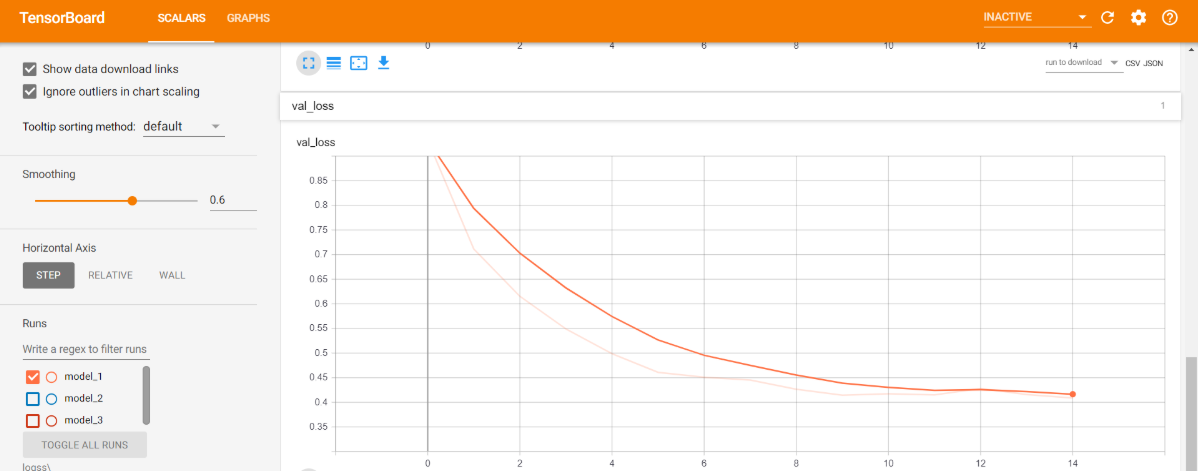

In [2]:
from IPython.display import Image
Image("Capture2.PNG")

### Model-2

Use the same model as above but for 'input_seq_total_text_data' give only some words in the sentance not all the words. Filter the words as below. 

<pre>
1. Train the TF-IDF on the Train data <br>
2. Get the idf value for each word we have in the train data. <br>
3. Remove the low idf value and high idf value words from our data. Do some analysis on the Idf values and based on those values choose the low and high threshold value. Because very frequent words and very very rare words don't give much information. (you can plot a box plots and take only the idf scores within IQR range and corresponding words)<br>
4. Train the LSTM after removing the Low and High idf value words. (In model-1 Train on total data but in Model-2 train on data after removing some words based on IDF values)
</pre>

In [0]:
import tensorflow as tf
tf.__version__

'1.15.0'

In [0]:
project_data = pd.read_csv('drive/My Drive/lstm_donor/processed_data.csv')
#target = project_data['']

In [0]:
project_data.columns
target = project_data['project_is_approved']
#project_data.drop(['Unnamed :0','id','teacher_id','project_is_approved'],axis = 1,inplace = True)

In [0]:
project_data.drop(['Unnamed: 0','id','teacher_id','project_is_approved'],axis = 1,inplace = True)

In [7]:
#splitting the data in train,validation and test 
from sklearn.model_selection import train_test_split
#80% training data and 20% test data 
X_train,X_test,Y_train,Y_test = train_test_split(project_data,target,test_size = 0.2,stratify = target,random_state = 42)
X_train,X_cv,Y_train,Y_cv = train_test_split(X_train,Y_train,test_size = 0.2,stratify = Y_train,random_state = 42)

print('shape of training data after vectorization is:',X_train.shape)
print('shape of validation data after vectorization is:',X_cv.shape)
print('shape of test data after vectorization is:',X_test.shape)

shape of training data after vectorization is: (69918, 14)
shape of validation data after vectorization is: (17480, 14)
shape of test data after vectorization is: (21850, 14)


## TFIDF Model

In [8]:
project_data.columns

Index(['teacher_prefix', 'school_state', 'project_submitted_datetime',
       'project_grade_category', 'project_subject_categories',
       'project_subject_subcategories',
       'teacher_number_of_previously_posted_projects', 'price', 'quantity',
       'cleaned_project_titles', 'cleaned_resource_summary', 'essay',
       'cleaned_essay', 'nrm_price'],
      dtype='object')

In [0]:
#utility function
def final_text(df):
    """Returns the final concatenated text"""
    df['final_Text'] = df['cleaned_essay'].map(str) + " " + df['cleaned_resource_summary'].map(str) +\
        " " + df['cleaned_project_titles'].map(str)
    return df

#getting the train,val and test data
X_train = final_text(X_train)
X_cv= final_text(X_cv)
X_test = final_text(X_test)

In [10]:
X_train.columns

Index(['teacher_prefix', 'school_state', 'project_submitted_datetime',
       'project_grade_category', 'project_subject_categories',
       'project_subject_subcategories',
       'teacher_number_of_previously_posted_projects', 'price', 'quantity',
       'cleaned_project_titles', 'cleaned_resource_summary', 'essay',
       'cleaned_essay', 'nrm_price', 'final_Text'],
      dtype='object')

In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer()

tfidf.fit(X_train['final_Text'])
corpus = tfidf.get_feature_names() #getting names of all the features
idf_corpus = tfidf.idf_ #getting the  idf scores 

dict_corpus_idf = dict(zip(corpus,idf_corpus))
print('Number of wordds in the corpus are:',len(dict_corpus_idf))

Number of wordds in the corpus are: 51124


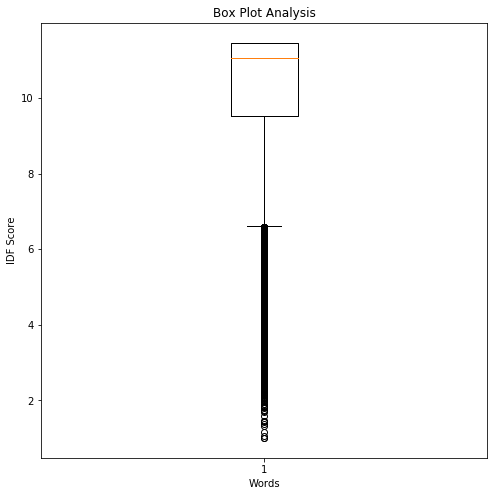

The lowest significant value of TF-IDF Scores:  3
The highest significant value of TF-IDF Scores:  11.4619455276077


In [0]:
p_75th = np.percentile(idf_corpus,59.81896)
p_75th
import matplotlib.pyplot as plt
plt.figure(figsize=(8,8))
plt.boxplot(idf_corpus)
plt.title('Box Plot Analysis')
plt.xlabel('Words')
plt.ylabel('IDF Score')
plt.show()

p_25th = 3
p_75th = np.percentile(idf_corpus,75)
#p_75th = 11.555

print("The lowest significant value of TF-IDF Scores: ",p_25th)
print("The highest significant value of TF-IDF Scores: ",p_75th)

In [0]:
#creating the list of words to be removed from the corpus
removed_wordlist = []
for word in list(dict_corpus_idf.keys()):
    if(dict_corpus_idf[word] < p_25th or dict_corpus_idf[word] > p_75th):
        removed_wordlist.append(word)
    else:
        continue
        
print("Number of words to be removed: ",len(removed_wordlist))

Number of words to be removed:  141


In [0]:
def remove_from_text(list_of_sentences):
    """This function will be used to remove words from text data"""
    processed_text = []
    for sentence in tqdm(list_of_sentences):
        sent = ' '.join(word for word in sentence.split() if word not in removed_wordlist) #We will keep only those words in title which has a string length greater than one
        processed_text.append(sent)
    return processed_text

X_train['total_text'] = remove_from_text(X_train.final_Text.values)
X_cv['total_text'] = remove_from_text(X_cv.final_Text.values)
X_test['total_text'] = remove_from_text(X_test.final_Text.values)

100%|██████████| 21850/21850 [00:04<00:00, 4496.13it/s]


In [0]:
X_train.to_csv("X_train_removed.csv", index=False)
X_cv.to_csv("X_val_removed.csv", index=False)
X_test.to_csv("X_test_removed.csv", index=False)

In [0]:
X_train = pd.read_csv("X_train_removed.csv")
X_val = pd.read_csv("X_val_removed.csv")
X_test = pd.read_csv("X_test_removed.csv")

## Total Text data 

In [0]:
#Get the total_text values in list
docs_text_train=list(X_train.total_text.values)
docs_text_val=list(X_val.total_text.values)
docs_text_test=list(X_test.total_text.values)
labels_train=np.array(Y_train)
labels_val=np.array(Y_cv)
labels_test=np.array(Y_test)

#Initializing the keras tokenizer and fitting it on train data
tokens = Tokenizer()
tokens.fit_on_texts(docs_text_train)

#Convert the texts to sequences using the tokenizer
sequences_text_train = tokens.texts_to_sequences(docs_text_train)
sequences_text_val = tokens.texts_to_sequences(docs_text_val)
sequences_text_test = tokens.texts_to_sequences(docs_text_test)
vocab_size_text = len(tokens.word_index) + 1

#Add padding
padded_text_train = pad_sequences(sequences_text_train, maxlen=300, padding='post')
padded_text_val = pad_sequences(sequences_text_val, maxlen=300, padding='post')
padded_text_test = pad_sequences(sequences_text_test, maxlen=300, padding='post')

In [0]:
pickle_in = open("drive/My Drive/lstm_donor/glove_vectors","rb")
glove_words = pickle.load(pickle_in)
embedding_matrix = zeros((vocab_size_text, 300))
for word, i in tokens.word_index.items(): #enumerating all unique words
    embedding_vector = glove_words.get(word)#locating for loaded glove model
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [0]:
#Get the flattened LSTM output for input text
import warnings
warnings.filterwarnings('ignore')
input_layer_total_text = Input(shape=(300,), name = "total_text_sequence")
embedding_layer_total_text = Embedding(input_dim=vocab_size_text, output_dim=300, weights=[embedding_matrix], trainable=False)(input_layer_total_text)
lstm_total_text  = LSTM(16, activation="relu", return_sequences=True)(embedding_layer_total_text)
flatten_total_text = Flatten()(lstm_total_text)

In [0]:
# teacher prefix
#Get the teacher_prefix values
docs_teacher_prefix_train=list(X_train.teacher_prefix.values)
docs_teacher_prefix_val=list(X_val.teacher_prefix.values)
docs_teacher_prefix_test=list(X_test.teacher_prefix.values)

#Initializing the keras tokenizer and fitting it on train data
tokens = Tokenizer()
tokens.fit_on_texts(docs_teacher_prefix_train)

#Convert the school_state to sequences using the tokenizer
sequences_teacher_prefix_train = np.array(tokens.texts_to_sequences(docs_teacher_prefix_train))
sequences_teacher_prefix_val = np.array(tokens.texts_to_sequences(docs_teacher_prefix_val))
sequences_teacher_prefix_test = np.array(tokens.texts_to_sequences(docs_teacher_prefix_test))
vocab_size_teacher_prefix = len(tokens.word_index) + 1
#Get the flattened output for teacher_prefix
input_layer_teacher_prefix = Input(shape=(1,), name = "teacher_prefix")
embedding_layer_teacher_prefix = Embedding(input_dim=vocab_size_teacher_prefix, output_dim=4, trainable=True)(input_layer_teacher_prefix)
flatten_teacher_prefix = Flatten()(embedding_layer_teacher_prefix)

## Categorical data : school_state

In [0]:

#Get the school state values
docs_school_state_train=list(X_train.school_state.values)
docs_school_state_val=list(X_val.school_state.values)
docs_school_state_test=list(X_test.school_state.values)

#Initializing the keras tokenizer and fitting it on train data
tokens = Tokenizer()
tokens.fit_on_texts(docs_school_state_train)

#Convert the school_state to sequences using the tokenizer
sequences_school_train = np.array(tokens.texts_to_sequences(docs_school_state_train))
sequences_school_val = np.array(tokens.texts_to_sequences(docs_school_state_val))
sequences_school_test = np.array(tokens.texts_to_sequences(docs_school_state_test))
vocab_size_school_state = len(tokens.word_index) + 1
#Get the flattened output for school_state
input_layer_school_state = Input(shape=(1,), name = "encoded_school_state")
embedding_layer_school_state = Embedding(input_dim=vocab_size_school_state, output_dim=4, trainable=True)(input_layer_school_state)
flatten_school_state = Flatten()(embedding_layer_school_state)


## Categorical data : project_grade_category

In [0]:
#Get the project_grade_category values
docs_project_grade_category_train=list(X_train.project_grade_category.values)
docs_project_grade_category_val=list(X_val.project_grade_category.values)
docs_project_grade_category_test=list(X_test.project_grade_category.values)

#Initializing the keras tokenizer and fitting it on train data
tokens = Tokenizer()
tokens.fit_on_texts(docs_project_grade_category_train)

#Convert the school_state to sequences using the tokenizer
sequences_project_grade_category_train = tokens.texts_to_sequences(docs_project_grade_category_train)
sequences_project_grade_category_val = tokens.texts_to_sequences(docs_project_grade_category_val)
sequences_project_grade_category_test = tokens.texts_to_sequences(docs_project_grade_category_test)
vocab_size_project_grade_category= len(tokens.word_index) + 1

#Add padding
padded_project_grade_category_train = pad_sequences(sequences_project_grade_category_train, maxlen=3, padding='post')
padded_project_grade_category_val = pad_sequences(sequences_project_grade_category_val, maxlen=3, padding='post')
padded_project_grade_category_test = pad_sequences(sequences_project_grade_category_test, maxlen=3, padding='post')
#Get the flattened output for project_grade_category
input_layer_project_grade = Input(shape=(3,), name = "project_grade_category")
embedding_layer_project_grade = Embedding(input_dim=vocab_size_project_grade_category, output_dim=4, trainable=True)(input_layer_project_grade)
flatten_project_grade = Flatten()(embedding_layer_project_grade)

## Categorical data : clean categories

In [0]:
X_train.columns

Index(['teacher_prefix', 'school_state', 'project_submitted_datetime',
       'project_grade_category', 'project_subject_categories',
       'project_subject_subcategories',
       'teacher_number_of_previously_posted_projects', 'price', 'quantity',
       'cleaned_project_titles', 'cleaned_resource_summary', 'essay',
       'cleaned_essay', 'nrm_price', 'final_Text', 'total_text'],
      dtype='object')

In [0]:
#Get the clean_categories values
docs_clean_categories_train=list(X_train.project_subject_categories.values)
docs_clean_categories_val=list(X_val.project_subject_categories.values)
docs_clean_categories_test=list(X_test.project_subject_categories.values)

#Initializing the keras tokenizer and fitting it on train data
tokens = Tokenizer()
tokens.fit_on_texts(docs_clean_categories_train)

#Convert the school_state to sequences using the tokenizer
sequences_clean_categories_train = tokens.texts_to_sequences(docs_clean_categories_train)
sequences_clean_categories_val = tokens.texts_to_sequences(docs_clean_categories_val)
sequences_clean_categories_test = tokens.texts_to_sequences(docs_clean_categories_test)
vocab_size_clean_categories = len(tokens.word_index) + 1

#Add padding
padded_clean_categories_train = pad_sequences(sequences_clean_categories_train, maxlen=3, padding='post')
padded_clean_categories_val = pad_sequences(sequences_clean_categories_val, maxlen=3, padding='post')
padded_clean_categories_test = pad_sequences(sequences_clean_categories_test, maxlen=3, padding='post')
#Get the flattened output for clean_categories
input_layer_clean_categories = Input(shape=(3,), name = "clean_categories")
embedding_layer_clean_categories = Embedding(input_dim=vocab_size_clean_categories, output_dim=4, trainable=True)(input_layer_clean_categories)
flatten_clean_categories = Flatten()(embedding_layer_clean_categories)

## Categorical data : project subcategories

In [0]:
#Get the clean_subcategories values
docs_clean_subcategories_train=list(X_train.project_subject_subcategories.values)
docs_clean_subcategories_val=list(X_val.project_subject_subcategories.values)
docs_clean_subcategories_test=list(X_test.project_subject_subcategories.values)

#Initializing the keras tokenizer and fitting it on train data
tokens = Tokenizer()
tokens.fit_on_texts(docs_clean_subcategories_train)

#Convert the school_state to sequences using the tokenizer
sequences_clean_subcategories_train = tokens.texts_to_sequences(docs_clean_subcategories_train)
sequences_clean_subcategories_val = tokens.texts_to_sequences(docs_clean_subcategories_val)
sequences_clean_subcategories_test = tokens.texts_to_sequences(docs_clean_subcategories_test)
vocab_size_clean_subcategories = len(tokens.word_index) + 1

padded_clean_subcategories_train = pad_sequences(sequences_clean_subcategories_train, maxlen=3, padding='post')
padded_clean_subcategories_val = pad_sequences(sequences_clean_subcategories_val, maxlen=3, padding='post')
padded_clean_subcategories_test = pad_sequences(sequences_clean_subcategories_test, maxlen=3, padding='post')
#Get the flattened output for clean_subcategories
input_layer_clean_subcategories = Input(shape=(3,), name = "clean_subcategories")
embedding_layer_clean_subcategories = Embedding(input_dim=vocab_size_clean_subcategories, output_dim=4, trainable=True)(input_layer_clean_subcategories)
flatten_clean_subcategories = Flatten()(embedding_layer_clean_subcategories)

In [0]:
from sklearn.preprocessing import Normalizer

def normalize_vars(data):
    """This function is used to normalize all the input datas between 0 and 1"""
    normalizer = Normalizer()
    data_normalized = normalizer.fit_transform(data.reshape(1, -1))
    return data_normalized, normalizer

In [0]:
previous_projects_train = X_train.teacher_number_of_previously_posted_projects.values
previous_projects_val = X_val.teacher_number_of_previously_posted_projects.values
previous_projects_test = X_test.teacher_number_of_previously_posted_projects.values

norm_previous_projects_train, normalizer = normalize_vars(previous_projects_train.reshape(1,-1))
norm_previous_projects_val = normalizer.transform(previous_projects_val.reshape(1,-1))
norm_previous_projects_test = normalizer.transform(previous_projects_test.reshape(1,-1))

norm_previous_projects_train = norm_previous_projects_train.reshape(len(X_train),1)
norm_previous_projects_val = norm_previous_projects_val.reshape(len(X_val),1)
norm_previous_projects_test = norm_previous_projects_test.reshape(len(X_test),1)
#Input layer for teacher_number_of_previously_posted_projects
input_layer_previous_projects = Input(shape=(1,), name = "previous_projects")
#price
#Building train, test and validation data
price_train = X_train.price.values
price_val = X_val.price.values
price_test = X_test.price.values

norm_price_train, normalizer = normalize_vars(price_train.reshape(1,-1))
norm_price_val = normalizer.transform(price_val.reshape(1,-1))
norm_price_test = normalizer.transform(price_test.reshape(1,-1))

norm_price_train = norm_price_train.reshape(len(X_train),1)
norm_price_val = norm_price_val.reshape(len(X_val),1)
norm_price_test = norm_price_test.reshape(len(X_test),1)
#Input layer for price
input_layer_price = Input(shape=(1,), name = "price")
#quantity
#Building train and validation data
quantity_train = X_train.quantity.values
quantity_val = X_val.quantity.values
quantity_test = X_test.quantity.values

norm_quantity_train, normalizer = normalize_vars(quantity_train.reshape(1,-1))
norm_quantity_val = normalizer.transform(quantity_val.reshape(1,-1))
norm_quantity_test = normalizer.transform(quantity_test.reshape(1,-1))

norm_quantity_train = norm_quantity_train.reshape(len(X_train),1)
norm_quantity_val = norm_quantity_val.reshape(len(X_val),1)
norm_quantity_test = norm_quantity_test.reshape(len(X_test),1)
#Input layer for quantity
input_layer_quantity = Input(shape=(1,), name = "quantity")

In [0]:
# concatenating all
numerical_features_layers_concat = concatenate([input_layer_previous_projects, input_layer_price, input_layer_quantity])
dense_layer_numerical = Dense(6, activation='relu',kernel_initializer='he_normal')(numerical_features_layers_concat)

In [0]:
# Merge all the layers according to the architecture diagram
x = concatenate([flatten_total_text, flatten_teacher_prefix, flatten_school_state, flatten_project_grade, flatten_clean_categories, flatten_clean_subcategories, dense_layer_numerical])
x = Dense(10, activation='relu',kernel_initializer='he_normal',name='dense_layer_1')(x)
x = Dropout(0.3, name='dropout_1')(x)
x = Dense(10, activation='relu',kernel_initializer='he_normal',name='dense_layer_2')(x)
x = Dropout(0.3, name='dropout_2')(x)
output_layer = Dense(1, activation='sigmoid', name='output_layer')(x)

# Final model
model = Model(inputs=[input_layer_total_text,input_layer_teacher_prefix,input_layer_school_state,input_layer_project_grade,input_layer_clean_categories,
                      input_layer_clean_subcategories,input_layer_previous_projects,input_layer_price,input_layer_quantity], outputs=[output_layer])
model.summary()


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
total_text_sequence (InputLayer (None, 300)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 300, 300)     15303600    total_text_sequence[0][0]        
__________________________________________________________________________________________________
teacher_prefix (InputLayer)     (None, 1)            0                                            
__________________________________________________________________________________________________
encoded_school_state (InputLaye (None, 1)            0                     

In [0]:
from keras import backend as K
from sklearn.metrics import roc_auc_score
#https://stackoverflow.com/questions/51922500/tf-metrics-auc-yielding-very-different-from-sklearn-metrics-roc-auc-score
def roc_auc(y_true, y_pred):
    auc = tf.py_func(roc_auc_score, (y_true, y_pred), tf.double)
    #auc = tf.metrics.auc(y_true, y_pred, num_thresholds=200)[1]
    K.get_session().run(tf.local_variables_initializer())
    return auc
#Defining callbacks
from time import time
#from tensorflow.python.keras.callbacks import TensorBoard
from keras.callbacks import ModelCheckpoint
from keras.callbacks import TensorBoard

tensorboard = TensorBoard(log_dir="logs".format(time))
filepath="weights_best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_roc_auc', verbose=1, save_best_only=True, mode='max')
import gc
gc.collect()

5

In [0]:
import tensorflow as tf

In [0]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[roc_auc])
model.fit(x=[padded_text_train,sequences_teacher_prefix_train,sequences_school_train,padded_project_grade_category_train,padded_clean_categories_train,padded_clean_subcategories_train,
             norm_previous_projects_train,norm_price_train,norm_quantity_train], 
          y=[labels_train],
          validation_data=([padded_text_val,sequences_teacher_prefix_val,sequences_school_val,padded_project_grade_category_val,padded_clean_categories_val,padded_clean_subcategories_val,
                            norm_previous_projects_val,norm_price_val,norm_quantity_val],[labels_val]),
          epochs=7, 
          batch_size=1024, 
          callbacks=[tensorboard])



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, there are two
    options available in V2.
    - tf.py_function takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    - tf.numpy_function maintains the semantics of the deprecated tf.py_func
    (it is not differentiable, and manipulates numpy arrays). It drops the
    stateful argument making all functions stateful.
    


Train on 69918 samples, validate on 17480 samples


Epoch 1/7
69918/69918 [==============================] - 39s 557us/step - loss: 0.4618 - roc_auc: 0.5689 - val_loss: 0.4135 - val_roc_auc: 0.7006

Epoch 2/7
69918/69918 [=======

In [0]:
!tensorboard --logdir=logs/ --host=127.0.0.1

TensorBoard 1.15.0 at http://127.0.0.1:6006/ (Press CTRL+C to quit)


###  Auc on test data

In [0]:
test_data=[padded_text_test,sequences_teacher_prefix_test,sequences_school_test,padded_project_grade_category_test,
                  padded_clean_categories_test,padded_clean_subcategories_test,norm_previous_projects_test,norm_price_test,norm_quantity_test]

In [0]:
#Test AUC
y_pred= model.predict(test_data)
print("AUC on unseen test data: ",roc_auc_score(Y_test,y_pred))


AUC on unseen test data:  0.7275554325048124


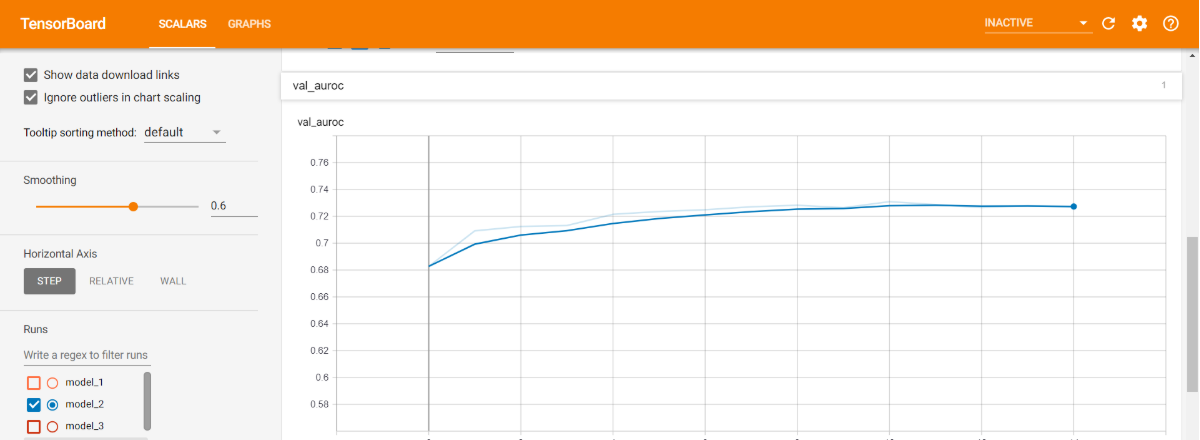

In [3]:
from IPython.display import Image
Image("Capture3.PNG")

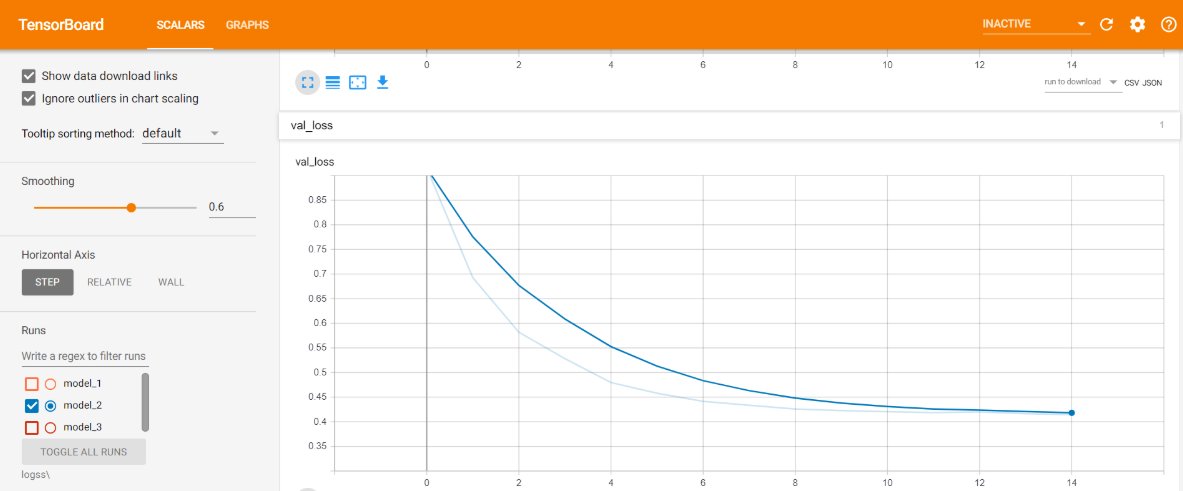

In [4]:
from IPython.display import Image
Image("Capture4.PNG")

### Model-3

<img src='https://i.imgur.com/fkQ8nGo.png'>
ref: https://i.imgur.com/fkQ8nGo.png


- __input_seq_total_text_data__: <br>
<pre>
    . Use text column('essay'), and use the Embedding layer to get word vectors. <br>
    . Use given predefined glove word vectors, don't train any word vectors. <br>
    . Use LSTM that is given above, get the LSTM output and Flatten that output. <br>
    . You are free to preprocess the input text as you needed. <br>
</pre>
- __Other_than_text_data__:<br>
<pre>
    . Convert all your Categorical values to onehot coded and then concatenate all these onehot vectors <br>
    . Neumerical values and use <a href='https://keras.io/getting-started/sequential-model-guide/#sequence-classification-with-1d-convolutions'>CNN1D</a> as shown in above figure. <br>
    . You are free to choose all CNN parameters like kernel sizes, stride.<br>
    
</pre>

In [0]:
X_train.columns

Index(['teacher_prefix', 'school_state', 'project_submitted_datetime',
       'project_grade_category', 'project_subject_categories',
       'project_subject_subcategories',
       'teacher_number_of_previously_posted_projects', 'price', 'quantity',
       'cleaned_project_titles', 'cleaned_resource_summary', 'essay',
       'cleaned_essay', 'nrm_price', 'final_Text'],
      dtype='object')

In [0]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(fil_words)
seq_train = tokenizer.texts_to_sequences(X_train["final_Text"])
seq_cv = tokenizer.texts_to_sequences(X_cv['final_Text'])
seq_test = tokenizer.texts_to_sequences(X_test["final_Text"])

vocab_size_text = len(tokenizer.word_index)+1 #vocablury size of the data 

#Add padding
padded_text_train = pad_sequences(seq_train, maxlen=300, padding='post')
padded_text_val = pad_sequences(seq_cv, maxlen=300, padding='post')
padded_text_test = pad_sequences(seq_test, maxlen=300, padding='post')

In [15]:
pickle_in = open("drive/My Drive/lstm_donor/glove_vectors","rb")
glove_words = pickle.load(pickle_in)
embedding_matrix = zeros((vocab_size_text, 300))
for word, i in tokenizer.word_index.items(): #enumerating all unique words
    embedding_vector = glove_words.get(word)#locating for loaded glove model
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

print('the shappe of embedding matrix is:',embedding_matrix.shape)

the shappe of embedding matrix is: (24730, 300)


In [0]:
# input_text = Input(shape=(800,),name="input_text")
import warnings
warnings.filterwarnings('ignore')
from keras import regularizers
input_text = Input(shape=(300,),name="input_text")
embedding_layer = Embedding(vocab_size_text,output_dim = 300,weights=[embedding_matrix],trainable=False)
x = embedding_layer(input_text)
x = LSTM(256,recurrent_dropout=0.5,kernel_regularizer=regularizers.l2(0.001),return_sequences=True)(x)
flat_1 = Flatten()(x)

In [0]:
X_train.columns

Index(['teacher_prefix', 'school_state', 'project_submitted_datetime',
       'project_grade_category', 'project_subject_categories',
       'project_subject_subcategories',
       'teacher_number_of_previously_posted_projects', 'price', 'quantity',
       'cleaned_project_titles', 'cleaned_resource_summary', 'essay',
       'cleaned_essay', 'nrm_price', 'final_Text'],
      dtype='object')

In [0]:
vect = CountVectorizer(binary=True)
vect.fit(X_train["teacher_prefix"])
train_prefix = vect.transform(X_train["teacher_prefix"])
val_prefix = vect.transform(X_cv['teacher_prefix'])
test_prefix = vect.transform(X_test["teacher_prefix"])

vect = CountVectorizer(binary=True)
vect.fit(X_train["school_state"])
train_state = vect.transform(X_train["school_state"])
val_state = vect.transform(X_cv["school_state"])
test_state = vect.transform(X_test["school_state"])

vect = CountVectorizer(binary=True)
vect.fit(X_train["school_state"])
train_grade = vect.transform(X_train["project_grade_category"])
val_grade = vect.transform(X_cv["project_grade_category"])
test_grade = vect.transform(X_test["project_grade_category"])

vect = CountVectorizer(binary=True)
vect.fit(X_train["project_subject_categories"])
train_subcat = vect.transform(X_train["project_subject_categories"])
val_subcat = vect.transform(X_cv["project_subject_categories"])
test_subcat = vect.transform(X_test["project_subject_categories"])

vect = CountVectorizer(binary=True)
vect.fit(X_train["project_subject_subcategories"])
train_subcat_1 = vect.transform(X_train["project_subject_subcategories"])
val_subcat_1 = vect.transform(X_cv["project_subject_subcategories"])
test_subcat_1 = vect.transform(X_test["project_subject_subcategories"])

In [0]:
#for all the numerical features 

#numerical_train_a=X_train['digits_in_summary'].values.reshape(-1, 1)
num_train_1=X_train['price'].values.reshape(-1, 1)
num_train_2=X_train['quantity'].values.reshape(-1, 1)
num_train_3=X_train['teacher_number_of_previously_posted_projects'].values.reshape(-1, 1)


num_val_1=X_cv['price'].values.reshape(-1, 1)
num_val_2=X_cv['quantity'].values.reshape(-1, 1)
num_val_3=X_cv['teacher_number_of_previously_posted_projects'].values.reshape(-1, 1)

#numerical_test_a=X_test['digits_in_summary'].values.reshape(-1, 1)
num_test_1=X_test['price'].values.reshape(-1, 1)
num_test_2=X_test['quantity'].values.reshape(-1, 1)
num_test_3=X_test['teacher_number_of_previously_posted_projects'].values.reshape(-1, 1)

In [ ]:
numerical_train=np.concatenate((num_train_1,num_train_2,num_train_3),axis=1)
numerical_val=np.concatenate((num_val_1,num_val_2,num_val_3),axis=1)
numerical_test=np.concatenate((num_test_1,num_test_2,num_test_3),axis=1)

from sklearn.preprocessing import StandardScaler
normal=StandardScaler()
normal_train=normal.fit_transform(numerical_train)
normal_val=normal.fit_transform(numerical_val)
normal_test=normal.transform(numerical_test)

In [0]:
from scipy.sparse import hstack
other_train = hstack([train_prefix,train_state,train_grade,train_subcat,train_subcat_1]).todense()
other_val = hstack([val_prefix,val_state,val_grade,val_subcat,val_subcat_1]).todense()
other_test = hstack([test_prefix,test_state,test_grade,test_subcat,test_subcat_1]).todense()
other_train = np.hstack((ot_train,normal_train))
other_val = np.hstack((ot_val,normal_val))
other_test = np.hstack((ot_test,normal_test))
other_train_all = np.expand_dims(ot_all_train,2)
other_val_all = np.expand_dims(ot_all_val,2)
other_test_all = np.expand_dims(ot_all_test,2)

In [22]:
from keras.layers import Input, Embedding, LSTM, Dropout, BatchNormalization, Dense, concatenate, Flatten, Conv1D, MaxPool1D, LeakyReLU, ELU, SpatialDropout1D, MaxPooling1D, GlobalAveragePooling1D, GlobalMaxPooling1D
inp_conv=Input(shape=(other_all_train.shape[1], 1))
x1 = Conv1D(filters=128, kernel_size=3, activation='relu',kernel_initializer="he_normal")(inp_conv)
x1 = Conv1D(filters=128, kernel_size=3, activation='relu',kernel_initializer="he_normal")(x1)
x1 = Flatten()(x1)

In [0]:

x_concatenate = concatenate([flat_1,x1])
x = Dense(128,activation="relu",kernel_initializer="he_normal",kernel_regularizer=regularizers.l2(0.001))(x_concatenate)
x=Dropout(0.5)(x)
x = Dense(64,activation="relu",kernel_initializer="he_normal",kernel_regularizer=regularizers.l2(0.001))(x)
x=Dropout(0.3)(x)
x = Dense(32,activation="relu",kernel_initializer="he_normal",kernel_regularizer=regularizers.l2(0.001))(x)
output = Dense(2, activation='softmax', name='output')(x)
model_1 = Model(inputs=[input_text,inp_conv],outputs=[output])

In [0]:
train_data_3 = [padded_text_train,ot_train_all]
val_data_3 = [padded_text_val,ot_val_all]
test_data_3 = [padded_text_test,ot_test_all]
from keras.utils import np_utils
Y_train = np_utils.to_categorical(Y_train, 2) 
Y_val = np_utils.to_categorical(Y_cv, 2) 
Y_test = np_utils.to_categorical(Y_test, 2)

In [0]:
from sklearn.metrics import roc_auc_score
def auc1(y_true, y_pred):
    if len(np.unique(y_true[:,1])) == 1:
        return 0.5
    else:
        return roc_auc_score(y_true, y_pred)
def auroc(y_true, y_pred):
    return tf.py_func(auc1, (y_true, y_pred), tf.double)

In [0]:
from keras.optimizers import Adam
import tensorflow as tf

In [27]:
model_1.compile(optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False), loss='categorical_crossentropy', metrics=[auroc])



Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, there are two
    options available in V2.
    - tf.py_function takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    - tf.numpy_function maintains the semantics of the deprecated tf.py_func
    (it is not differentiable, and manipulates numpy arrays). It drops the
    stateful argument making all functions stateful.
    


In [0]:

checkpoint_3 = ModelCheckpoint("model_3.h5",monitor="val_auroc",mode="max",save_best_only = True,verbose=1)
NAME = 'model_3'
tensorboard_2 = TensorBoard(log_dir='logs')
callbacks_2 = [tensorboard_2,checkpoint_3]

In [37]:
history_1 = model_1.fit(train_data_3,Y_train,batch_size=512,epochs=15,validation_data=(val_data_3,Y_val),verbose=1)

Train on 69918 samples, validate on 17480 samples
Epoch 1/15
69918/69918 [==============================] - 76s 1ms/step - loss: 0.8016 - auroc: 0.6520 - val_loss: 0.6379 - val_auroc: 0.7352
Epoch 2/15
69918/69918 [==============================] - 75s 1ms/step - loss: 0.5536 - auroc: 0.7216 - val_loss: 0.5570 - val_auroc: 0.7476
Epoch 3/15
69918/69918 [==============================] - 74s 1ms/step - loss: 0.4930 - auroc: 0.7324 - val_loss: 0.5011 - val_auroc: 0.7417
Epoch 4/15
69918/69918 [==============================] - 75s 1ms/step - loss: 0.4623 - auroc: 0.7346 - val_loss: 0.4821 - val_auroc: 0.7493
Epoch 5/15
69918/69918 [==============================] - 75s 1ms/step - loss: 0.4403 - auroc: 0.7460 - val_loss: 0.4691 - val_auroc: 0.7615
Epoch 6/15
69918/69918 [==============================] - 75s 1ms/step - loss: 0.4241 - auroc: 0.7544 - val_loss: 0.4552 - val_auroc: 0.7610
Epoch 7/15
69918/69918 [==============================] - 75s 1ms/step - loss: 0.4128 - auroc: 0.7587 - 

In [40]:
#Test AUC
y_pred= model_1.predict(test_data_3)
print("AUC on unseen test data: ",roc_auc_score(Y_test,y_pred))

AUC on unseen test data:  0.7633947879300654


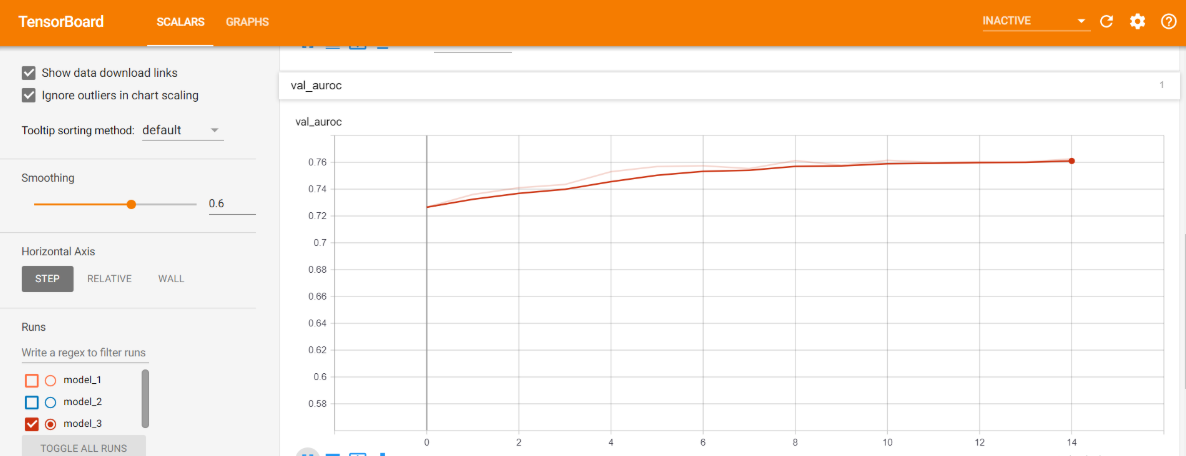

In [5]:
from IPython.display import Image
Image("Capture5.PNG")

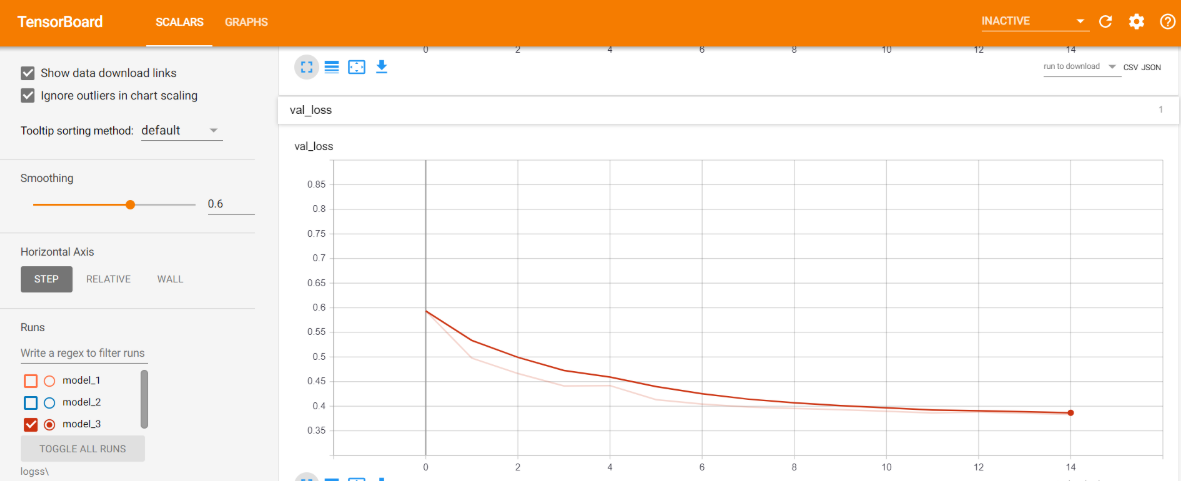

In [6]:
from IPython.display import Image
Image("Capture6.PNG")

In [12]:
from prettytable import PrettyTable
table =PrettyTable()
table.field_names = ["Model No", "Trained for Epochs", "Train ROC-AUC", "Validation ROC-AUC", "Test ROC-AUC"]
table.add_row(["Model 1",10,0.7988,0.7169,0.7148])
table.add_row(["Model 2",7,0.7287,0.7262,0.7275])
table.add_row(["Model 3",15,0.7678,0.7677,0.7633])
print(table)

+----------+--------------------+---------------+--------------------+--------------+
| Model No | Trained for Epochs | Train ROC-AUC | Validation ROC-AUC | Test ROC-AUC |
+----------+--------------------+---------------+--------------------+--------------+
| Model 1  |         10         |     0.7988    |       0.7169       |    0.7148    |
| Model 2  |         7          |     0.7287    |       0.7262       |    0.7275    |
| Model 3  |         15         |     0.7678    |       0.7677       |    0.7633    |
+----------+--------------------+---------------+--------------------+--------------+


# What was the case study all about and what we learnt


So this case study was an application of machine learning for social good where we we were able to automate the process of approving the projects being submitted for evaluation based on lots of different factors.

We tokenized the text data and one hot encoded the categorical variables and also performed normalization on the numerical features primarily ,along we that we performed the feature engineering with digits present in the text or not .

We also used pre embedded glove vectors as the main embedding layer for the text data.

Amongst all the three models, the 3rd model with 1D CNN layers seems to perform the best as we have got the maximum value of ROC-AUC for it.

Using RSM Prop with proper weight initialization was also resulting in exploding gradients for Model 1. Changing the optimizer to adam has changed this problem.
Got the loss curves and score curve using Tensorboard.
Used a custome metric function for training the model with a custom roc-auc score.
For TFIDF analysis, I first tried with the 25 percentile threshold for tfidf scores and the model performed very poorly despiting trying my best to optimize it. The lowest threshold I have considered for this assignment is 6.5 approximately.
Model 3 has given us the best value of ROC-AUC - just under 0.75.

For TFIDF analysis, I had previously tried with IDF score between 7 and max value, ut it resulted in huge loss of data. Hence I took IDF values which were greater than 3 and the model has improved a lot.